In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from startup import np, pd, plt, sns, sm, smf, os, Path

In [3]:
import ydf

In [58]:
# Scikit learn imports
from sklearn.manifold import TSNE
from sklearn.metrics import classification_report
from sklearn.cluster import HDBSCAN
from sklearn.decomposition import NMF, PCA

In [5]:
from plotly.offline import iplot
import plotly.graph_objs as go

In [6]:
# https://giotto-ai.github.io/gtda-docs/0.5.1/library.html
import gtda
from gtda.homology import VietorisRipsPersistence

In [7]:
from gtda.plotting import plot_diagram

In [8]:
data_dir = Path.home() / 'Work' / 'Data' / 'uci_adult'
df_train = pd.read_csv(data_dir / "adult_train.csv")
df_test = pd.read_csv(data_dir / "adult_test.csv")

In [9]:
df_train.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,44,Private,228057,7th-8th,4,Married-civ-spouse,Machine-op-inspct,Wife,White,Female,0,0,40,Dominican-Republic,<=50K
1,20,Private,299047,Some-college,10,Never-married,Other-service,Not-in-family,White,Female,0,0,20,United-States,<=50K
2,40,Private,342164,HS-grad,9,Separated,Adm-clerical,Unmarried,White,Female,0,0,37,United-States,<=50K
3,30,Private,361742,Some-college,10,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,50,United-States,<=50K
4,67,Self-emp-inc,171564,HS-grad,9,Married-civ-spouse,Prof-specialty,Wife,White,Female,20051,0,30,England,>50K


In [10]:
df_train.describe(include='all')

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
count,22792.000000,21535,2.279200e+04,22792,22792.000000,22792,21532,22792,22792,22792,22792.000000,22792.000000,22792.000000,22385,22792
unique,NaN,8,NaN,16,NaN,7,14,6,5,2,NaN,NaN,NaN,41,2
top,NaN,Private,NaN,HS-grad,NaN,Married-civ-spouse,Prof-specialty,Husband,White,Male,NaN,NaN,NaN,United-States,<=50K
freq,NaN,15879,NaN,7340,NaN,10431,2870,9191,19467,15165,NaN,NaN,NaN,20436,17308
mean,38.615260,NaN,1.898792e+05,NaN,10.092664,NaN,NaN,NaN,NaN,NaN,1081.895665,87.280581,40.395534,NaN,NaN
std,13.661261,NaN,1.064256e+05,NaN,2.564326,NaN,NaN,NaN,NaN,NaN,7509.641193,403.018360,12.249235,NaN,NaN
min,17.000000,NaN,1.228500e+04,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,1.000000,NaN,NaN
25%,28.000000,NaN,1.176825e+05,NaN,9.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,40.000000,NaN,NaN
50%,37.000000,NaN,1.784590e+05,NaN,10.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,40.000000,NaN,NaN
75%,48.000000,NaN,2.374585e+05,NaN,12.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,45.000000,NaN,NaN


In [11]:
df_train.income.value_counts(normalize=True)

income
<=50K    0.759389
>50K     0.240611
Name: proportion, dtype: float64

In [12]:
# Train a Random Forest
model = ydf.RandomForestLearner(label="income", max_depth=8, num_trees=256).train(df_train)

Train model on 22792 examples
Model trained in 0:00:00.536379


In [13]:
model.describe()

In [14]:
model.evaluate(df_test).characteristics

[name: '>50K' vs others
 ROC AUC: 0.881669
 PR AUC: 0.743096
 Num thresholds: 253]

In [15]:
# Compare to GBT
model2 = ydf.GradientBoostedTreesLearner(label='income', ).train(df_train)
model2.evaluate(df_test).characteristics

Train model on 22792 examples
Model trained in 0:00:01.122926


[name: '>50K' vs others
 ROC AUC: 0.929601
 PR AUC: 0.831142
 Num thresholds: 9606]

In [16]:
model_gbt = ydf.GradientBoostedTreesLearner(
    label='income', max_depth=8, num_trees=256, # loss='BINARY_FOCAL_LOSS'
).train(df_train)
model_gbt.evaluate(df_test).characteristics

Train model on 22792 examples
Model trained in 0:00:01.200843


[name: '>50K' vs others
 ROC AUC: 0.929548
 PR AUC: 0.829446
 Num thresholds: 9451]

In [17]:
selected_example_idx = 0 # Change to select another example
selected_example = df_test[selected_example_idx:(selected_example_idx+1)]
selected_example

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K


In [18]:
model.predict_leaves(selected_example)

array([[30, 29, 24, 58, 23, 21, 14, 20, 16, 33, 75, 12, 14, 10, 17, 15,
        23, 17, 23, 33,  6, 13, 18, 24, 26, 18, 42, 35, 19, 47, 56, 17,
        51, 15, 42, 60, 53,  6, 24, 19,  5, 18, 28, 21, 19,  8, 32, 25,
        39, 12, 48, 14, 47, 13, 59, 22, 21, 28, 18, 59, 10, 25, 28, 10,
        68, 46, 23, 28, 36, 28,  6,  6,  4, 17, 30, 18, 35, 42, 25, 52,
        17, 55,  8, 25, 23, 30, 26, 27, 39, 24,  3, 19, 16, 23,  4,  9,
        42, 16, 48, 22,  6, 16, 16, 30, 42, 19, 27, 23, 32, 42,  9, 13,
         3, 29, 23, 12, 57, 13, 19, 24, 11, 48, 48, 43, 29,  3, 31, 44,
         9, 53, 28,  5, 21, 50, 31, 34, 32, 58,  7, 25, 25, 16, 18, 27,
        11, 30, 22, 42, 18, 26, 17, 19,  5, 23, 28, 16, 14, 36,  6, 61,
        19,  3, 18, 19, 32, 49, 14, 16, 12, 26, 27, 45, 21, 25, 19, 18,
        17, 16,  8, 13, 15, 28, 49, 33,  3, 43, 19, 20,  1, 36,  4, 31,
        36, 22,  3, 57, 44, 17,  9, 39, 11, 33, 13,  9, 69, 23, 26, 11,
        18, 58, 17,  5, 13, 27, 14, 45,  9, 18, 23, 20, 51, 27, 

In [19]:
distances = model.distance(df_train, selected_example)

In [20]:
distances[:10]


array([[1.        ],
       [0.99609375],
       [0.96484375],
       [1.        ],
       [1.        ],
       [0.99609375],
       [1.        ],
       [1.        ],
       [0.92578125],
       [0.95703125]], dtype=float32)

In [21]:
t = model.get_tree(0)

In [22]:
distances = model.distance(df_test, df_test)

In [23]:
manifold = TSNE(
    # Number of dimensions to display. 3d is also possible.
    n_components=2,
    # Control the shape of the projection. Higher values create more
    # distinct but also more collapsed clusters. Can be in 5-50.
    perplexity=20,
    metric="precomputed",
    init="random",
    verbose=1,
    learning_rate="auto",
).fit_transform(distances)

[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 9769 samples in 0.037s...
[t-SNE] Computed neighbors for 9769 samples in 0.811s...
[t-SNE] Computed conditional probabilities for sample 1000 / 9769
[t-SNE] Computed conditional probabilities for sample 2000 / 9769
[t-SNE] Computed conditional probabilities for sample 3000 / 9769
[t-SNE] Computed conditional probabilities for sample 4000 / 9769
[t-SNE] Computed conditional probabilities for sample 5000 / 9769
[t-SNE] Computed conditional probabilities for sample 6000 / 9769
[t-SNE] Computed conditional probabilities for sample 7000 / 9769
[t-SNE] Computed conditional probabilities for sample 8000 / 9769
[t-SNE] Computed conditional probabilities for sample 9000 / 9769
[t-SNE] Computed conditional probabilities for sample 9769 / 9769
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 68.645714
[t-SNE] KL divergence after 1000 iterations: 0.726769


<Axes: >

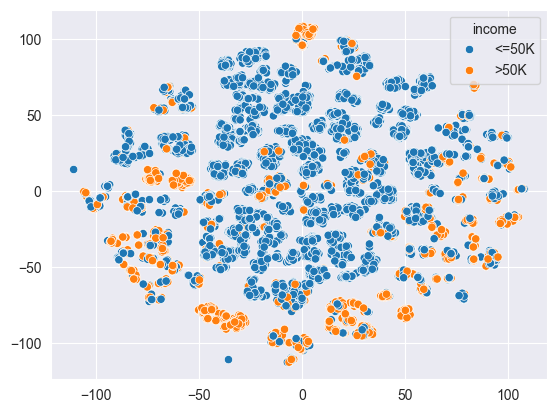

In [24]:
sns.scatterplot(x=manifold[:, 0], y=manifold[:, 1], hue=df_test.income)

In [25]:
VR = VietorisRipsPersistence(
    homology_dimensions=[0, 1], #, 2],
    metric='precomputed',
)

In [26]:
diagrams = VR.fit_transform(distances[None, :, :])

In [27]:
VR.plot(diagrams, 0)

/Users/mattmcd/Work/Projects/PyBayes/.venv/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning:

Clustering large matrix with scipy. Installing `fastcluster` may give better performance.

/Users/mattmcd/Work/Projects/PyBayes/.venv/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning:

Clustering large matrix with scipy. Installing `fastcluster` may give better performance.



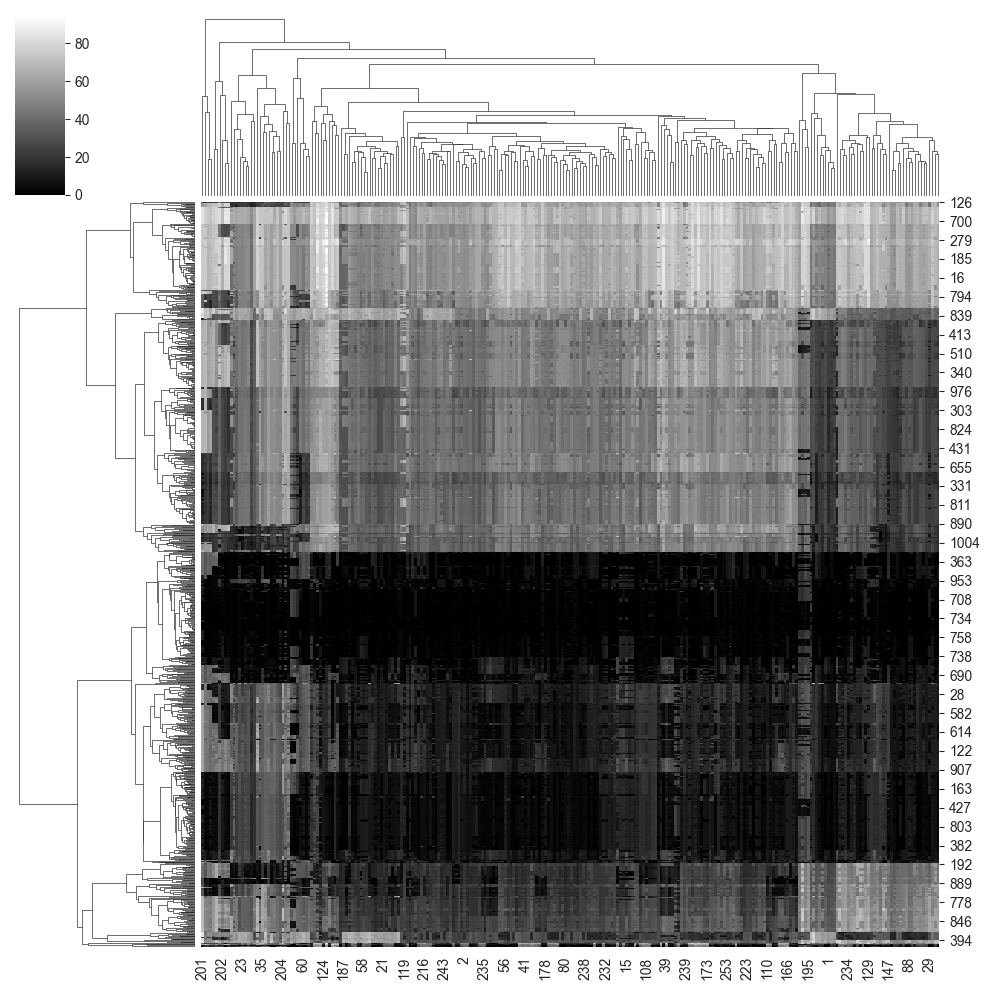

In [34]:
sns.clustermap(model.predict_leaves(df_test.sample(1024, random_state=42)), cmap='grey')

In [74]:
df_rf_leaves = pd.DataFrame(model.predict_leaves(df_test)).pipe(lambda x: x - x.mean())

<Axes: >

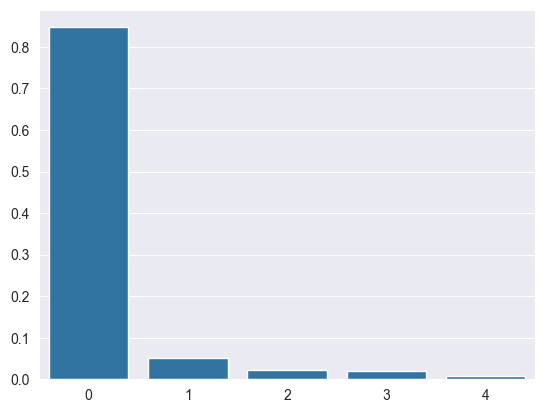

In [75]:
pca = PCA(n_components=5)
df_rf_leaves_pca = pd.DataFrame(pca.fit_transform(df_rf_leaves))
sns.barplot(pca.explained_variance_ratio_,)

In [85]:
manifold_rf = TSNE(n_components=3).fit_transform(df_rf_leaves)

In [91]:
rf_cluster = HDBSCAN().fit(df_rf_leaves)
# rf_cluster = HDBSCAN().fit(manifold_rf)

In [93]:
df_test_rf_cluster = df_test.assign(
    cluster=rf_cluster.labels_, label=lambda x: 1*(x.income == '>50K')
).groupby('cluster').label.agg(['count', 'mean']).sort_values('count', ascending=False)

In [103]:
df_test_rf_cluster.query('mean == 0. or mean == 1')['count'].sum()

3417

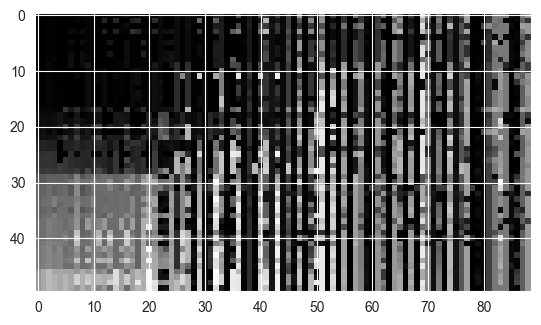

In [46]:
plt.imshow(pd.DataFrame(model_gbt.predict_leaves(df_test.sample(50, random_state=42))).sort_values(by=[0, 25]), cmap='grey')

In [39]:
distances_gbt = model_gbt.distance(df_test, df_test)

In [40]:
manifold_gbt = TSNE(
    # Number of dimensions to display. 3d is also possible.
    n_components=2,
    # Control the shape of the projection. Higher values create more
    # distinct but also more collapsed clusters. Can be in 5-50.
    perplexity=20,
    metric="precomputed",
    init="random",
    verbose=1,
    learning_rate="auto",
).fit_transform(distances_gbt)

[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 9769 samples in 0.043s...
[t-SNE] Computed neighbors for 9769 samples in 0.943s...
[t-SNE] Computed conditional probabilities for sample 1000 / 9769
[t-SNE] Computed conditional probabilities for sample 2000 / 9769
[t-SNE] Computed conditional probabilities for sample 3000 / 9769
[t-SNE] Computed conditional probabilities for sample 4000 / 9769
[t-SNE] Computed conditional probabilities for sample 5000 / 9769
[t-SNE] Computed conditional probabilities for sample 6000 / 9769
[t-SNE] Computed conditional probabilities for sample 7000 / 9769
[t-SNE] Computed conditional probabilities for sample 8000 / 9769
[t-SNE] Computed conditional probabilities for sample 9000 / 9769
[t-SNE] Computed conditional probabilities for sample 9769 / 9769
[t-SNE] Mean sigma: 0.080622
[t-SNE] KL divergence after 250 iterations with early exaggeration: 73.660576
[t-SNE] KL divergence after 1000 iterations: 0.967215


<Axes: >

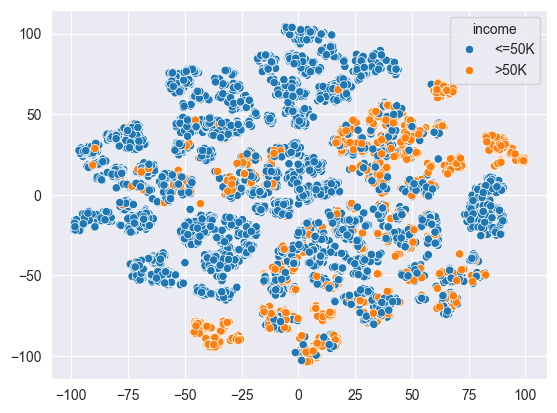

In [41]:
sns.scatterplot(x=manifold_gbt[:, 0], y=manifold_gbt[:, 1], hue=df_test.income)